 Imports

In [149]:
import numpy as np
import pandas as pd
import genData
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

Load our data sets for consistant and reproducible results

In [150]:
seed = 17263198
testDataSeed = 3718299
genData.def_seed = seed

In [151]:
trainA = genData.create_A()
testA = genData.create_A(seed=testDataSeed)
trainA

,x,y,target
0,-72.05,12.27,1
1,82.43,-8.91,-1
2,-79.91,7.74,1
3,82.41,-47.73,-1
4,61.60,-75.47,-1
...,...,...,...
995,-33.21,43.14,1
996,40.93,7.44,1
997,-62.14,-5.86,-1
998,67.06,37.12,1


In [152]:
trainB = genData.create_B(size=1000)
testB = genData.create_B(seed=testDataSeed,size=1000)
"""
train_extra = {"x":[],"y":[],"target":[]}
test_extra = {"x":[],"y":[],"target":[]}


while len(train_extra["target"]) < 500 or len(test_extra["target"])<500:
    train_x = np.random.randint(-300,301)
    train_y = np.random.randint(-300,301)
    test_x = np.random.randint(-300,301)
    test_y = np.random.randint(-300,301)
    
    if 40000 <= train_x**2 + train_y**2 and train_x**2 + train_y**2 <= 90000:
        train_extra["x"].append(train_x/100)
        train_extra["y"].append(train_y/100)
        train_extra["target"].append(1)
    if 40000 <= test_x**2 + test_y**2 and test_x**2 + test_y**2 <= 90000:
        test_extra["x"].append(test_x/100)
        test_extra["y"].append(test_y/100)
        test_extra["target"].append(1)

train_extra = pd.DataFrame(train_extra)
trainB = trainB.append(train_extra,ignore_index=True).sample(frac=1).reset_index(drop=True)

test_extra = pd.DataFrame(test_extra)
testB = testB.append(test_extra,ignore_index=True)
"""
trainB

,x,y,target
0,-72.05,12.27,-1
1,82.43,-8.91,-1
2,-79.91,7.74,-1
3,82.41,-47.73,-1
4,61.60,-75.47,-1
...,...,...,...
995,-33.21,43.14,-1
996,40.93,7.44,-1
997,-62.14,-5.86,-1
998,67.06,37.12,-1


## Adaline Model

In [153]:
class Adaline:
    def __init__(self,seed:int = None, learning_rate:float=0.00001, bias:float=0.2, repeats:int=10000, possible_targets=None,epsilon=0.00000001):
        self.rng = np.random.RandomState(seed)
        self.repeats = repeats
        self.learning_rate = learning_rate
        self.bias = bias
        self.possible_targets = possible_targets
        self.epsilon = epsilon
        

    def fit(self,data,target,verbose:int=0,precision:int=4,max_step:int=10,logRate:int=5) -> dict:
        
        self.weights = self.rng.rand(data.shape[1],1)
        
        
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #logging
        past_MSE = [float("inf")]

        #save each epoch
        stats = {"Epoch":[],"bias":[],"MSE":[]}
        for feature_i in range(data.shape[0]):
            stats["w_"+str(feature_i)] = []
            stats["deltaW_"+str(feature_i)] = []
        

        #make sure we don't enter an infinite loop if our model doesn't converge
        for i in range(self.repeats):
            errors = []
            
            #repeat for all data samples
            for x_i in range(data.shape[1]):
                #sum(w_i*x_i) for all features 
                Y = self.bias + np.sum(data[:,[x_i]]*self.weights,axis=0)[0]
                pred = 0
                if Y>=0:
                    pred = 1
                else:
                    pred = -1

                delta = 0
                #adjust weights and bias if we guessed wrong
                if pred != target[x_i]:
                    delta = (target[x_i]-Y)
                    deltaW = self.learning_rate*delta*data[:,[x_i]]
                
                    self.weights = self.weights + deltaW
                    self.bias = self.bias+self.learning_rate*delta
                    
                #squared error 
                errors.append((delta**2))
                
            if len(errors) == 0:
                break
            mse = sum(errors)/len(errors)
            past_MSE.append(mse)

            if i%logRate == 0:
                #save stats of each value in our data
                stats["bias"].append(round(self.bias,precision))
                stats["MSE"].append(round(mse,precision))
                stats["Epoch"].append(i)
                for feature_i in range(data.shape[0]):
                    stats["w_"+str(feature_i)].append(round(self.weights[feature_i][0],precision))
                    stats["deltaW_"+str(feature_i)].append(round(deltaW[feature_i][0],precision))
            
            #print stats
            if verbose>=1 and i%logRate == 0:
                print("Epoch",i)
                print(mse)
                if verbose>=2:
                    df = pd.DataFrame(stats)
                    print(df)
                print("--------")

            #stop if our mse is not changing at all
            if len(past_MSE) > max_step and all(past_MSE[-1] == x for x in past_MSE[-max_step:]):
                break
        
        model_performance = pd.DataFrame(stats)
        return model_performance


    def predict(self,data):
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #get vector of predicted target values
        raw_target = np.ravel(self.bias+np.sum(data*self.weights,axis=0))
        target = []
        for Y in raw_target:
            if Y>=0:
                target.append(1)
            else:
                target.append(-1)
        return np.array(target)

## Part A

In [154]:
ad = Adaline(seed, bias=0.1,learning_rate=0.0001)
perfomance = ad.fit(trainA.loc[:,["x","y"]],trainA["target"],verbose=1, logRate = 10)

Epoch 0
0.2389540296062442
--------
Epoch 10
0.007836130447574308
--------
Epoch 20
0.00773624064983353
--------
Epoch 30
0.007669259084376174
--------
Epoch 40
0.00760285829673631
--------
Epoch 50
0.0075370322326089485
--------
Epoch 60
0.007471775918401725
--------
Epoch 70
0.007407084423592658
--------
Epoch 80
0.007342952860323647
--------
Epoch 90
0.007279376383031307
--------
Epoch 100
0.007216350188081023
--------
Epoch 110
0.007153869513404155
--------
Epoch 120
0.007091929638138373
--------
Epoch 130
0.0070305258822711296
--------
Epoch 140
0.006969653606286201
--------
Epoch 150
0.006909308210813284
--------
Epoch 160
0.006849485136280633
--------
Epoch 170
0.0067901798625706975
--------
Epoch 180
0.006731387908678742
--------
Epoch 190
0.006673104832374413
--------
Epoch 200
0.006615326229866254
--------
Epoch 210
0.00655804773546909
--------
Epoch 220
0.006501265021274325
--------
Epoch 230
0.006444973796823062
--------
Epoch 240
0.006389169808782078
--------
Epoch 250
0.0

In [155]:
testA_res = ad.predict(testA.loc[:,["x","y"]])
accuracy_score(testA["target"],testA_res)

0.999

### Model progression 

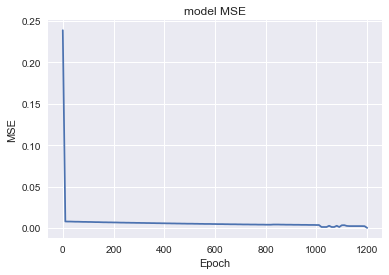

In [156]:
plt.plot(perfomance["Epoch"],perfomance["MSE"])
plt.title("model MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [157]:
perfomance

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
0,0,0.0989,0.2390,-0.0080,-0.0011,0.6053,-0.0001
1,10,0.0934,0.0078,-0.0071,-0.0011,0.6032,-0.0001
2,20,0.0886,0.0077,-0.0069,-0.0011,0.6007,-0.0001
3,30,0.0838,0.0077,-0.0069,-0.0011,0.5982,-0.0001
4,40,0.0790,0.0076,-0.0069,-0.0011,0.5957,-0.0001
...,...,...,...,...,...,...,...
116,1160,-0.3263,0.0022,-0.0039,-0.0064,0.3772,-0.0000
117,1170,-0.3284,0.0022,-0.0039,-0.0064,0.3762,-0.0000
118,1180,-0.3305,0.0022,-0.0038,-0.0064,0.3753,-0.0000
119,1190,-0.3326,0.0021,-0.0038,-0.0064,0.3743,-0.0000


In [158]:
ad2 = Adaline(seed,bias=0.000009671,learning_rate=0.000000002,repeats=10000)
perfomance2 = ad2.fit(trainB.loc[:,["x","y"]], trainB["target"], logRate = 10,verbose=1)

Epoch 0
650.079083096311
--------
Epoch 10
610.1014135809389
--------
Epoch 20
572.5900635929473
--------
Epoch 30
537.3907973203841
--------
Epoch 40
504.3613238103657
--------
Epoch 50
473.3674991921924
--------
Epoch 60
444.28452763829307
--------
Epoch 70
416.99249889344446
--------
Epoch 80
391.3815579802568
--------
Epoch 90
367.3478641818651
--------
Epoch 100
344.79648039457265
--------
Epoch 110
323.63163783171717
--------
Epoch 120
303.76951548808364
--------
Epoch 130
285.1288044777256
--------
Epoch 140
267.63601074110505
--------
Epoch 150
251.22053630892194
--------
Epoch 160
235.8138192917438
--------
Epoch 170
221.3545501086547
--------
Epoch 180
207.7843115093017
--------
Epoch 190
195.04829913806387
--------
Epoch 200
183.0950972971201
--------
Epoch 210
171.8764686836667
--------
Epoch 220
161.3471572264305
--------
Epoch 230
151.46375147996372
--------
Epoch 240
142.18850243902565
--------
Epoch 250
133.48197255840077
--------
Epoch 260
125.31103494060382
--------
E

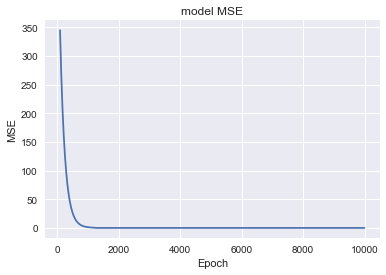

In [159]:
plt.plot(perfomance2["Epoch"][10:],perfomance2["MSE"][10:])
plt.title("model MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [160]:
testB_res = ad2.predict(testB.loc[:,["x","y"]])
testB_res

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [161]:
accuracy_score(testB["target"],testB_res)

0.997

In [162]:
perfomance2

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
0,0,-0.0000,650.0791,0.2341,-0.0,0.5793,-0.0
1,10,-0.0003,610.1014,0.2276,-0.0,0.5604,-0.0
2,20,-0.0006,572.5901,0.2213,-0.0,0.5422,-0.0
3,30,-0.0009,537.3908,0.2151,-0.0,0.5245,-0.0
4,40,-0.0012,504.3613,0.2091,-0.0,0.5074,-0.0
...,...,...,...,...,...,...,...
995,9950,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
996,9960,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
997,9970,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
998,9980,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0


In [163]:
models = []
scores = []
for bias in [0.001,0.01,0.1,1,10,100]:
    _ = Adaline(seed,bias=0.005,learning_rate=0.00005)
    scores.append(_.fit(trainB.loc[:,["x","y"]], trainB["target"], logRate = 10))
    models.append(_)
    print("done",bias)

done 0.001
done 0.01
done 0.1
done 1
done 10
done 100


In [164]:
scores

[     Epoch    bias     MSE     w_0  deltaW_0     w_1  deltaW_1
 0        0 -0.0299  5.8673 -0.0002    0.0018 -0.0014   -0.0023
 1       10 -0.0478  0.0988 -0.0004    0.0009 -0.0028    0.0008
 2       20 -0.0682  0.2110  0.0001   -0.0000  0.0001    0.0001
 3       30 -0.0695  0.0011  0.0001   -0.0000  0.0005    0.0001
 4       40 -0.0719  0.0216 -0.0006   -0.0000  0.0001    0.0001
 ..     ...     ...     ...     ...       ...     ...       ...
 995   9950 -0.1682  0.0014 -0.0004   -0.0000 -0.0006    0.0001
 996   9960 -0.1676  0.0014 -0.0005   -0.0000  0.0007    0.0001
 997   9970 -0.1683  0.0014 -0.0004   -0.0000 -0.0009    0.0001
 998   9980 -0.1677  0.0014 -0.0005   -0.0000  0.0005    0.0001
 999   9990 -0.1682  0.0133 -0.0016    0.0039 -0.0016    0.0019
 
 [1000 rows x 7 columns],
      Epoch    bias     MSE     w_0  deltaW_0     w_1  deltaW_1
 0        0 -0.0299  5.8673 -0.0002    0.0018 -0.0014   -0.0023
 1       10 -0.0478  0.0988 -0.0004    0.0009 -0.0028    0.0008
 2       20 

In [165]:
for mod in models:
    testB_res = mod.predict(testB.loc[:,["x","y"]])
    
    print(accuracy_score(testB["target"],testB_res))

0.999
0.999
0.999
0.999
0.999
0.999


In [166]:
perfomance2

,Epoch,bias,MSE,w_0,deltaW_0,w_1,deltaW_1
0,0,-0.0000,650.0791,0.2341,-0.0,0.5793,-0.0
1,10,-0.0003,610.1014,0.2276,-0.0,0.5604,-0.0
2,20,-0.0006,572.5901,0.2213,-0.0,0.5422,-0.0
3,30,-0.0009,537.3908,0.2151,-0.0,0.5245,-0.0
4,40,-0.0012,504.3613,0.2091,-0.0,0.5074,-0.0
...,...,...,...,...,...,...,...
995,9950,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
996,9960,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
997,9970,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0
998,9980,-0.0097,0.0010,0.0000,-0.0,0.0001,0.0


In [167]:
accuracy_score(testB["target"],testB_res)

0.999

In [168]:
testB["target"].value_counts()

-1    999
 1      1
Name: target, dtype: int64

In [169]:
testB["results"]=testB_res

In [170]:
testB["results"].value_counts()

-1    1000
Name: results, dtype: int64

In [171]:
backgroundPoints = [[],[]]
for i in range(-100,100):
    temp = []
    for j in range(-100,100):
        backgroundPoints[0].append(i*100)
        backgroundPoints[1].append(j*100)
print(np.array(backgroundPoints).shape)
backgroundPoints = genData.create_B(raw_data=backgroundPoints,size=None)
backgroundPoints

(2, 40000)


,x,y,target
0,-100.0,-100.0,-1
1,-100.0,-99.0,-1
2,-100.0,-98.0,-1
3,-100.0,-97.0,-1
4,-100.0,-96.0,-1
...,...,...,...
39995,99.0,95.0,-1
39996,99.0,96.0,-1
39997,99.0,97.0,-1
39998,99.0,98.0,-1


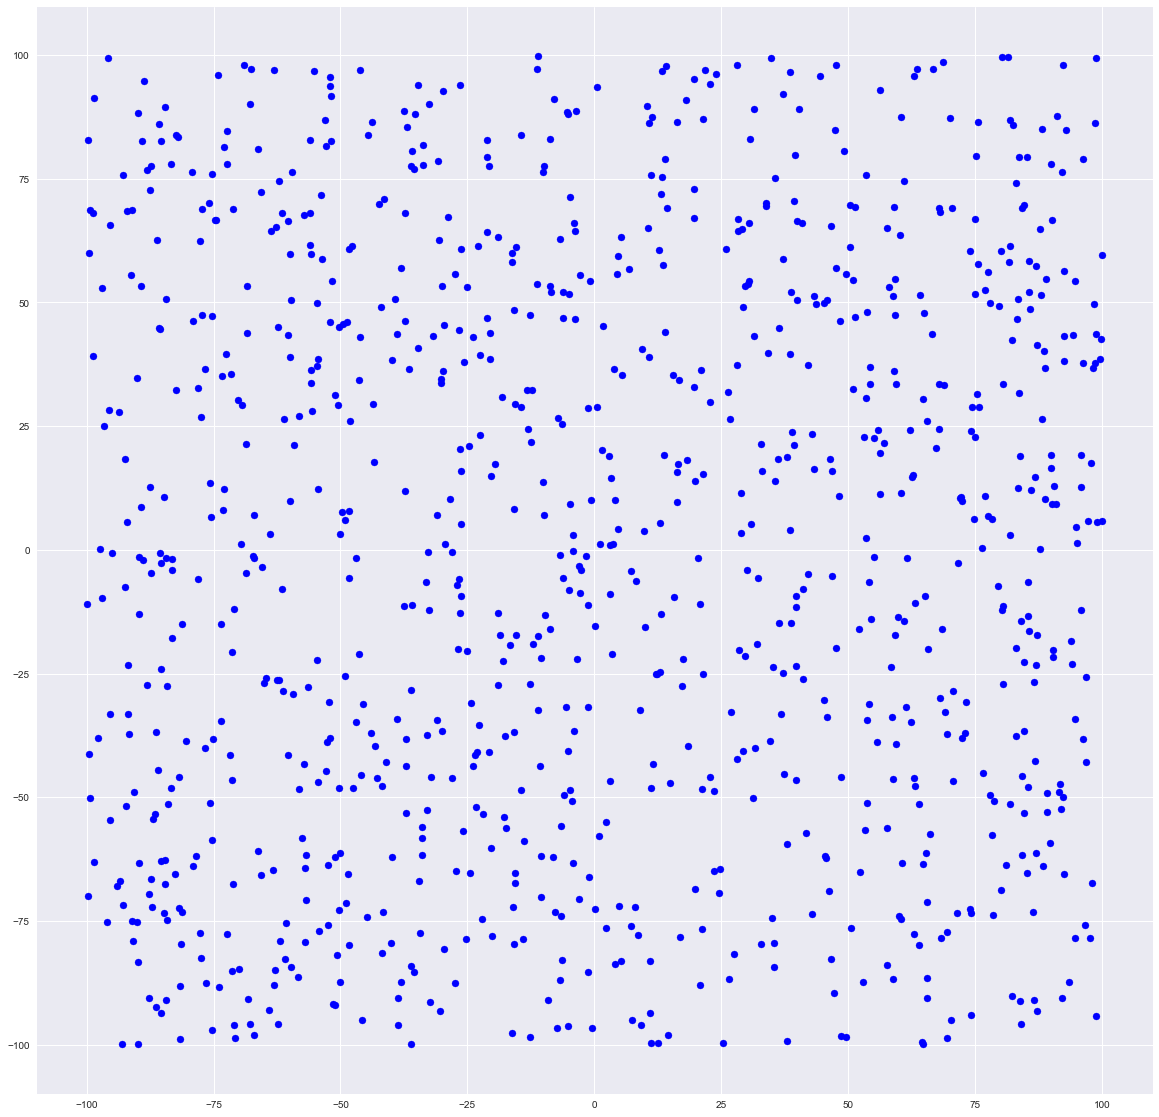

In [172]:
background_1 = backgroundPoints[backgroundPoints["target"] == 1]
background_neg_1 = backgroundPoints[backgroundPoints["target"] != 1]

targets_1 = testB[testB["results"] == 1]
targets_neg_1 = testB[testB["results"] != 1]

plt.figure(figsize=(20,20))
plt.scatter(targets_neg_1["x"],targets_neg_1["y"], c='b')
plt.scatter(targets_1["x"],targets_1["y"], c='r')

#plt.scatter(background_1["x"],background_1["y"], c='r',alpha=0.4)
#plt.scatter(background_neg_1["x"],background_neg_1["y"], c='b',alpha=0.4)

